### Financial Data E-Signature Prediction Model

### This script analyzes financial data to predict whether users will electronically sign documents.

### Key Steps:
1. Exploratory Data Analysis (EDA)
2. Feature Engineering
3. Model Comparison and Selection
4. Hyperparameter Tuning
5. Results Analysis

### 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score)
import time
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

### 2. Exploratory Data Analysis (EDA)


In [5]:
# Load dataset
dataset = pd.read_csv('P39-Financial-Data.csv')

# Initial exploration
print("Dataset shape:", dataset.shape)
print("\nFirst 5 rows:")
print(dataset.head())
print("\nDescriptive statistics:")
print(dataset.describe())

# Check for missing values
print("\nMissing values per column:")
print(dataset.isna().sum())

Dataset shape: (17908, 21)

First 5 rows:
   entry_id  age  pay_schedule  home_owner  income  months_employed  \
0   7629673   40     bi-weekly           1    3135                0   
1   3560428   61        weekly           0    3180                0   
2   6934997   23        weekly           0    1540                6   
3   5682812   40     bi-weekly           0    5230                0   
4   5335819   33  semi-monthly           0    3590                0   

   years_employed  current_address_year  personal_account_m  \
0               3                     3                   6   
1               6                     3                   2   
2               0                     0                   7   
3               6                     1                   2   
4               5                     2                   2   

   personal_account_y  ...  amount_requested  risk_score  risk_score_2  \
0                   2  ...               550       36200      0.737398   
1   

### 2.1 Data Visualization


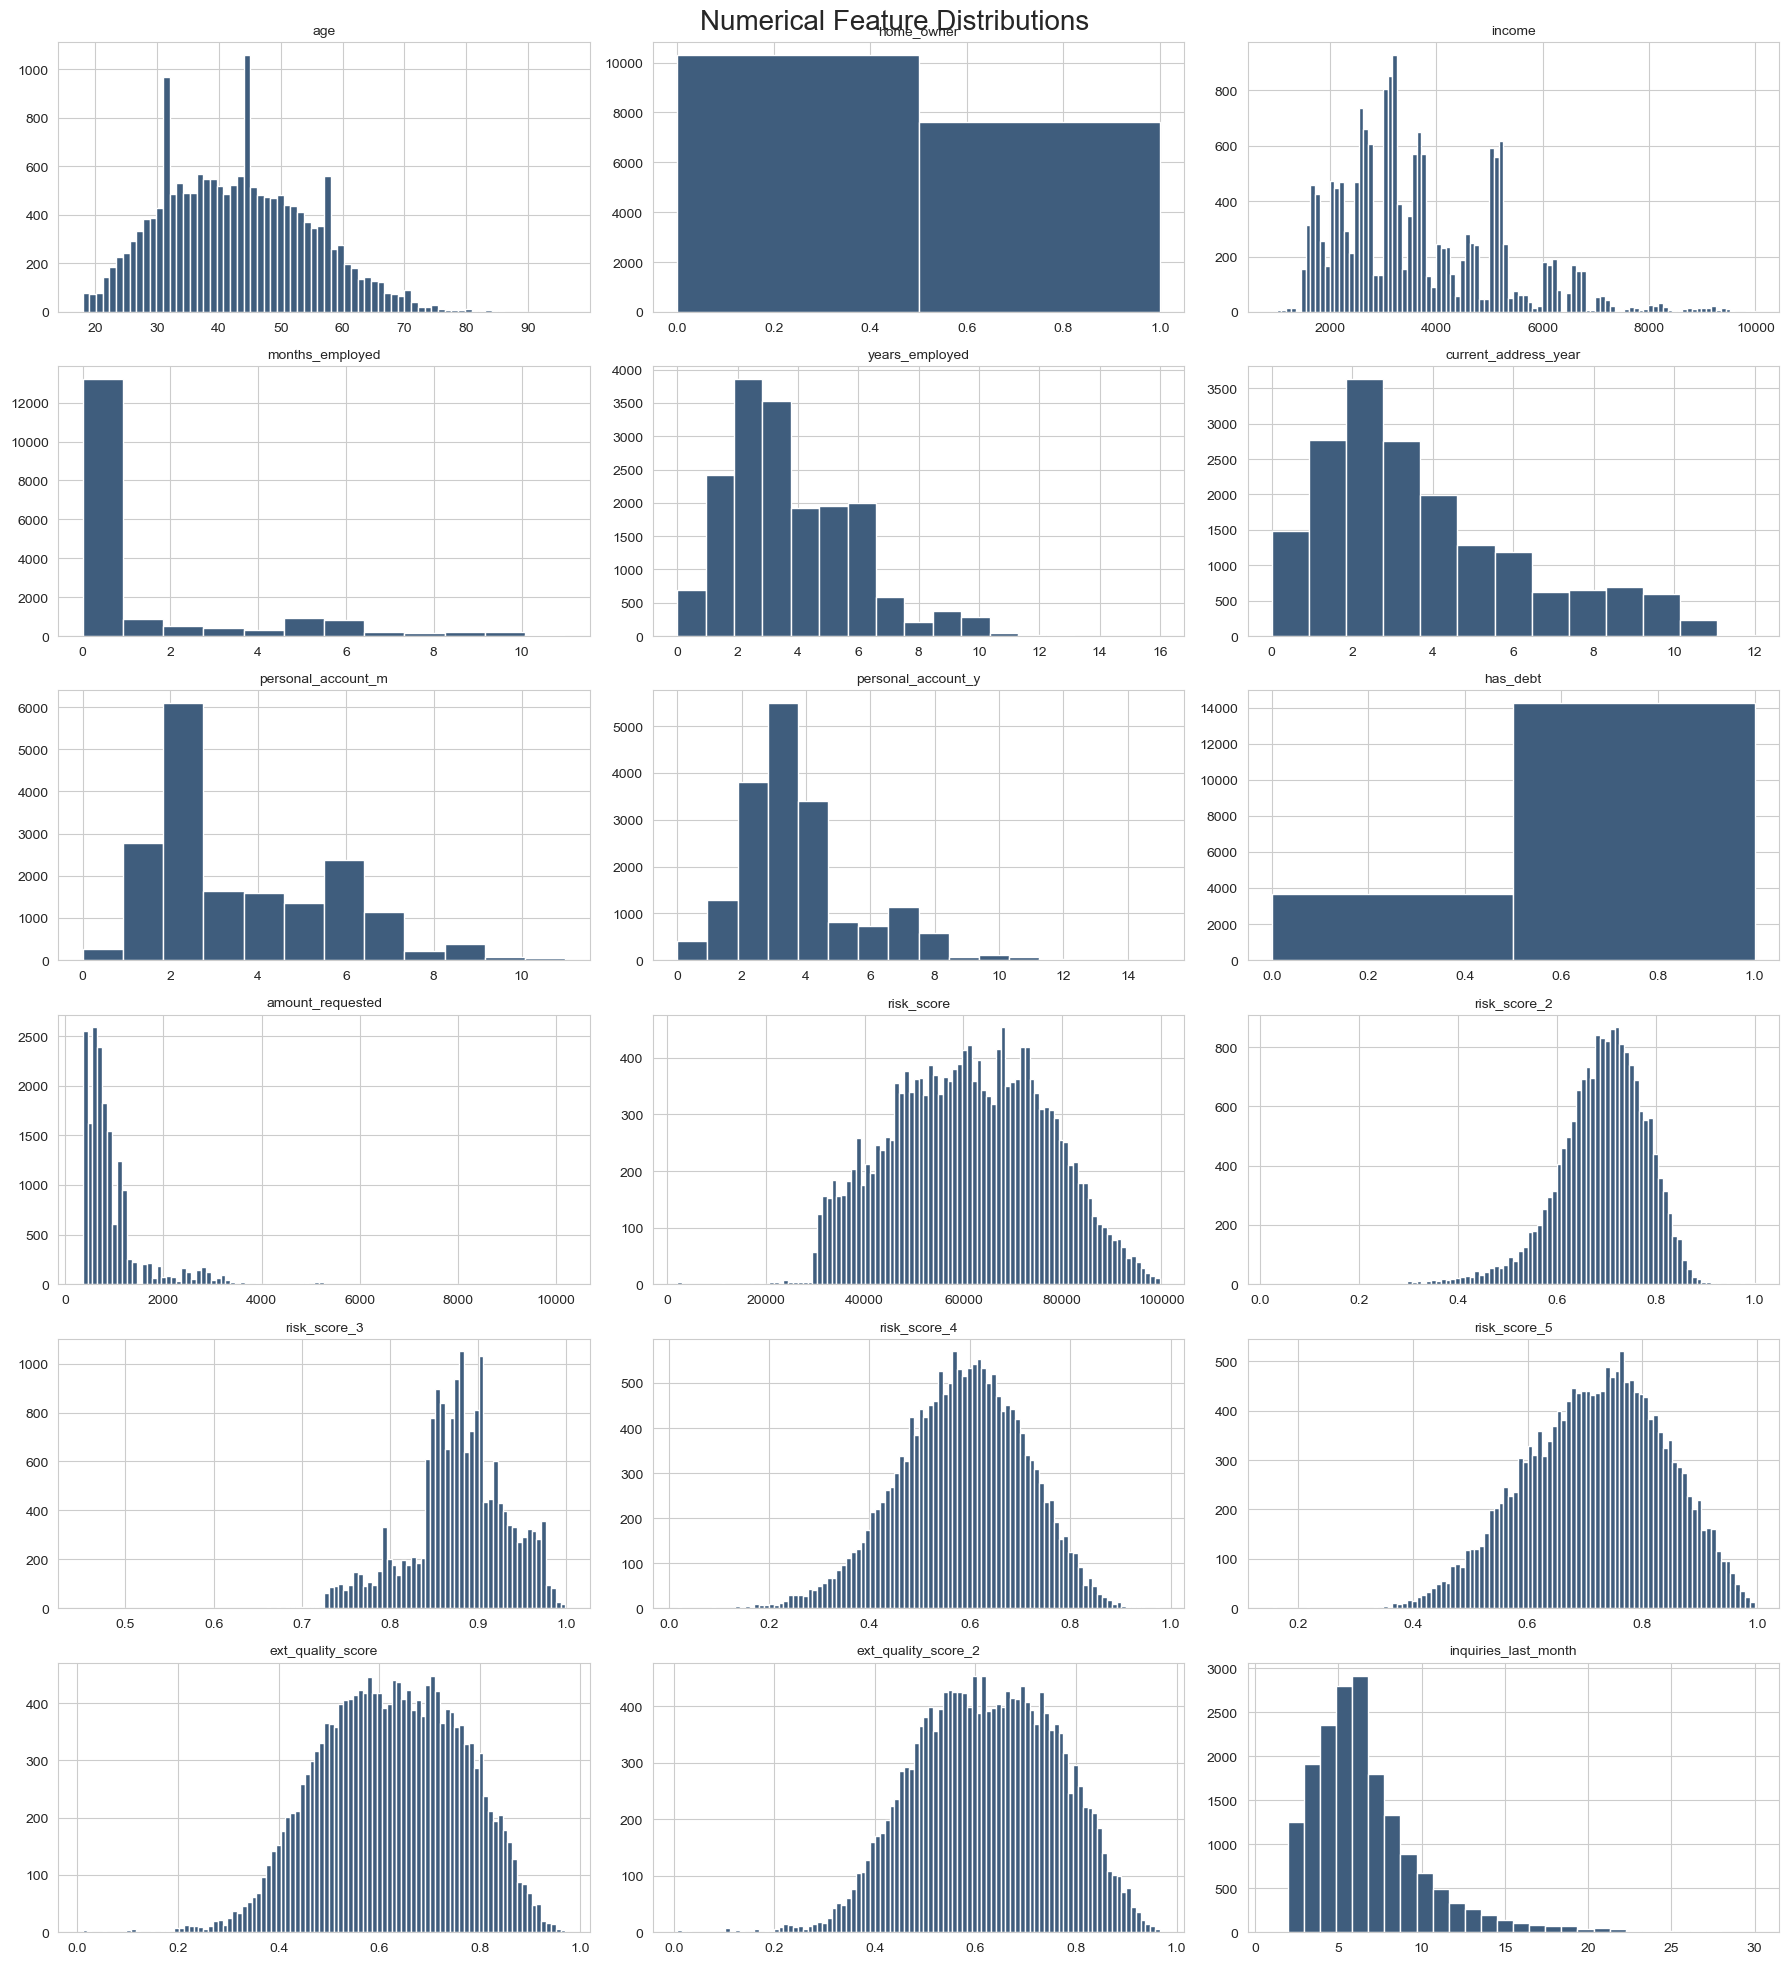

In [6]:
# Drop non-numeric columns for visualization
numeric_data = dataset.drop(columns=['entry_id', 'pay_schedule', 'e_signed'])

# Histograms for numerical features
plt.figure(figsize=(18, 20))
plt.suptitle('Numerical Feature Distributions', fontsize=20)
for i, col in enumerate(numeric_data.columns):
    plt.subplot(6, 3, i+1)
    vals = len(numeric_data[col].unique())
    bins = min(vals, 100)  # Limit to 100 bins for better visualization
    plt.hist(numeric_data[col], bins=bins, color='#3F5D7D')
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()

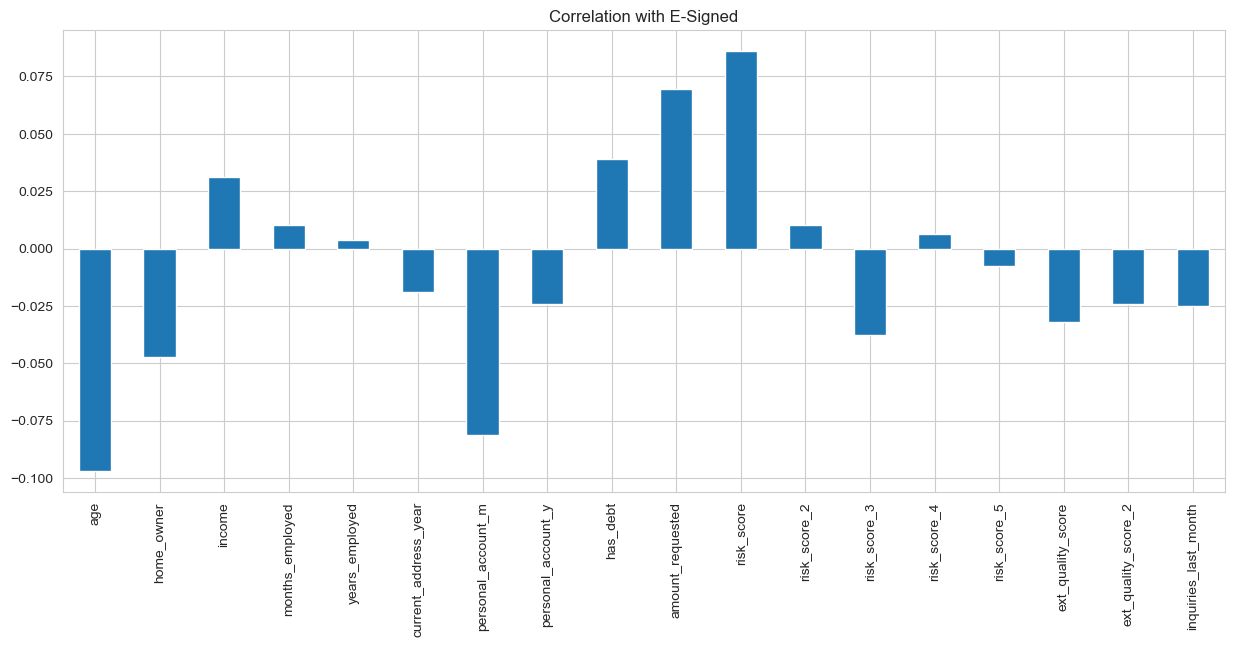

In [8]:
# Correlation with target
corr_with_target = numeric_data.corrwith(dataset['e_signed'])
corr_with_target.plot.bar(figsize=(15, 6), title='Correlation with E-Signed')
plt.show()

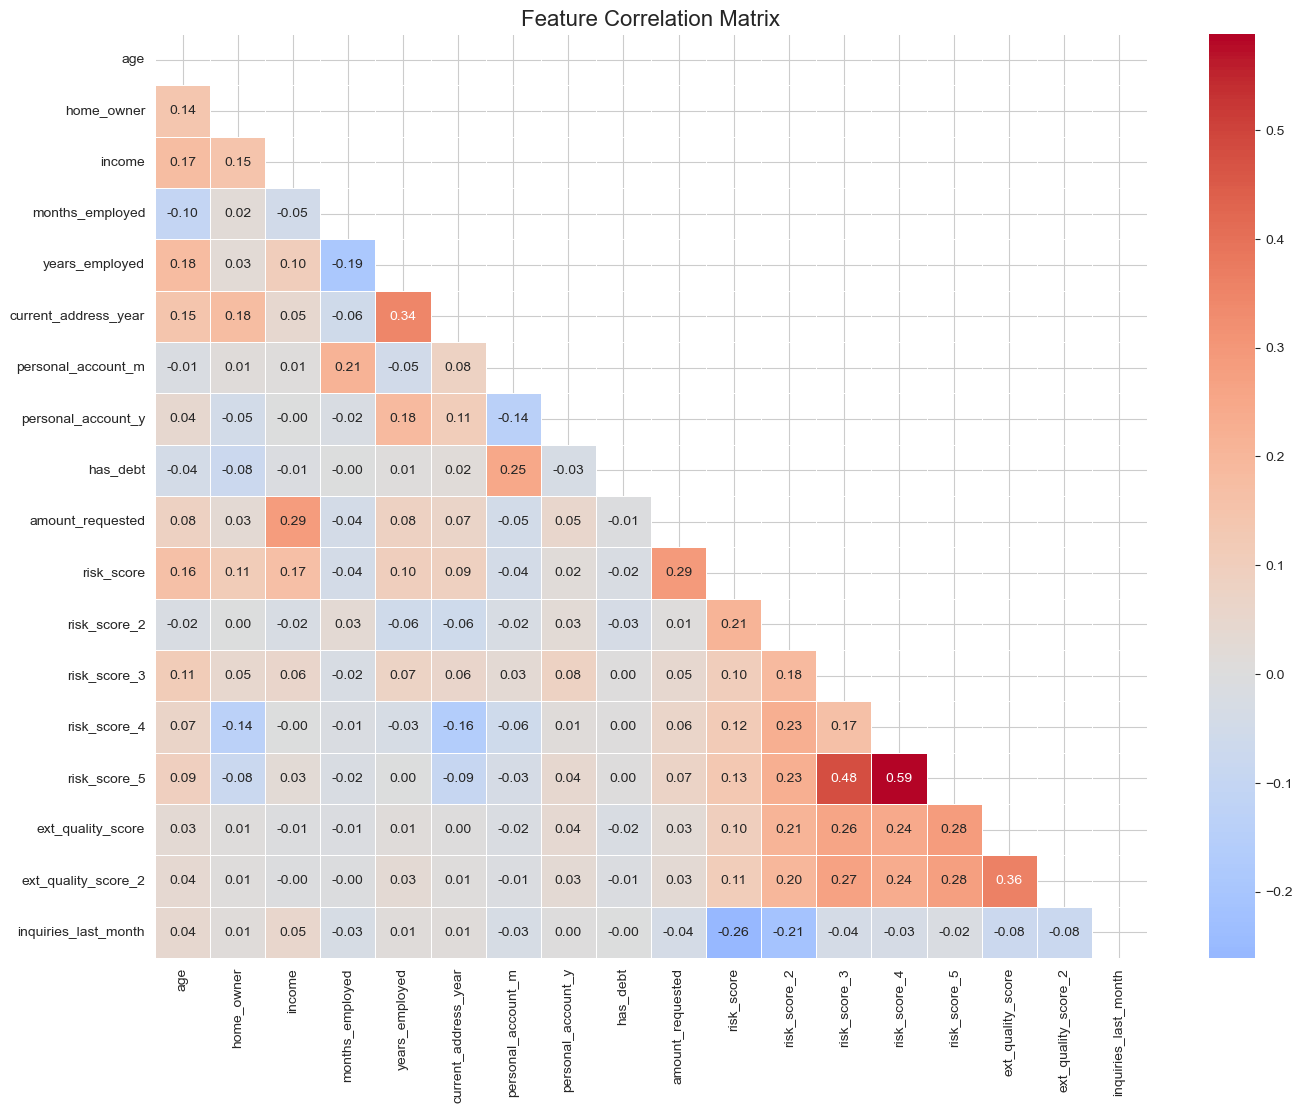

In [9]:
# Correlation matrix heatmap
corr_matrix = numeric_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

### 3. Feature Engineering

In [10]:
# Create combined feature for personal account months
dataset['personal_account_months'] = dataset['personal_account_m'] + (dataset['personal_account_y'] * 12)
dataset = dataset.drop(columns=['personal_account_m', 'personal_account_y', 'months_employed'])

# One-hot encode categorical variables
dataset = pd.get_dummies(dataset, columns=['pay_schedule'], drop_first=True)

# Separate features and target
response = dataset["e_signed"]
users = dataset['entry_id']
features = dataset.drop(columns=["e_signed", "entry_id"])

# Assign to variables
X = features
y = response
user_ids = users

### 4. Data Preparation


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### 5. Model Comparison


In [12]:
# Compare performance of different classification models
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

models = [
    ('Logistic Regression (L1)', LogisticRegression(random_state=42, penalty='l1', solver='liblinear')),
    ('SVM (Linear)', SVC(random_state=42, kernel='linear')),
    ('SVM (RBF)', SVC(random_state=42, kernel='rbf')),
    ('Random Forest (n=100)', RandomForestClassifier(random_state=42, n_estimators=100, criterion='entropy'))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    results = pd.concat([results, pd.DataFrame([metrics])], ignore_index=True)

# Cross-validation for best model
best_model = RandomForestClassifier(random_state=42, n_estimators=100, criterion='entropy')
cv_scores = cross_val_score(best_model, X_train, y_train, cv=10)
print(f"\nRandom Forest Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std()*2:.2f})")

# Print model comparison results
print("\nModel Comparison Results:")
print(results)


Random Forest Cross-Validation Accuracy: 0.63 (+/- 0.03)

Model Comparison Results:
                      Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression (L1)  0.577889   0.586093  0.734440  0.651934
1              SVM (Linear)  0.577889   0.583736  0.752075  0.657298
2                 SVM (RBF)  0.615857   0.623214  0.724066  0.669866
3     Random Forest (n=100)  0.630932   0.649261  0.683610  0.665993


### 6. Hyperparameter Tuning


In [13]:
# Perform grid search to optimize Random Forest hyperparameters
param_grid = [
    # Entropy-based tuning
    {
        'criterion': ['entropy'],
        'max_depth': [None],
        'max_features': [3, 5, 7],
        'min_samples_split': [8, 10, 12],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [True]
    },
    # Gini-based tuning
    {
        'criterion': ['gini'],
        'max_depth': [None],
        'max_features': [8, 10, 12],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [8, 10, 12],
        'bootstrap': [True]
    }
]

rf = RandomForestClassifier(random_state=42, n_estimators=100)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
print(f"\nGrid search completed in {end_time - start_time:.2f} seconds")
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Get the best estimator
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Grid search completed in 322.54 seconds
Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 12}
Best accuracy: 0.6336731176981376


### 7. Final Model Evaluation

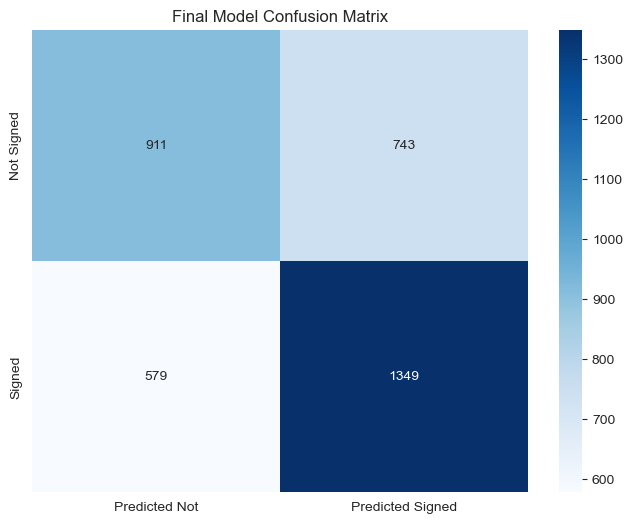


Top 10 Important Features:
                    Feature  Importance
7                risk_score    0.095959
6          amount_requested    0.094705
2                    income    0.086250
12        ext_quality_score    0.078141
9              risk_score_3    0.077599
8              risk_score_2    0.075671
15  personal_account_months    0.075262
10             risk_score_4    0.073090
11             risk_score_5    0.072961
13      ext_quality_score_2    0.072861

Final Model Metrics:
Accuracy: 0.6309
Precision: 0.6448
Recall: 0.6997
F1 Score: 0.6711


In [14]:
# Evaluate the final tuned model
y_pred = best_rf.predict(X_test)

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm, index=['Not Signed', 'Signed'], columns=['Predicted Not', 'Predicted Signed']), annot=True, fmt='d', cmap='Blues')
plt.title('Final Model Confusion Matrix')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# Print final model metrics
print("\nFinal Model Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

### 8. Results Analysis and Export

In [15]:
# Analyze and export final results with probabilities
# Get test set user IDs
test_users = user_ids.loc[y_test.index]

# Create results dataframe
results = pd.DataFrame({
    'entry_id': test_users,
    'e_signed': y_test,
    'predicted_e_signed': best_rf.predict(X_test),
    'sign_probability': best_rf.predict_proba(X_test)[:, 1]
}).reset_index(drop=True)

# Save results
results.to_csv('e_signature_predictions.csv', index=False)

# Analyze high-probability customers
high_prob = results[results.sign_probability >= 0.7].sort_values('sign_probability', ascending=False)
print(f"\n{len(high_prob)} high-probability customers identified (probability >= 70%)")


520 high-probability customers identified (probability >= 70%)
